<div class="alert alert-info"><center><h1>Prédiction de température par régression Linéaire</h1><c/enter></div

<blockquote style="border-left: 5px solid #686a91;">Dans ce notebook, deux données sont utilisées : 
- GlobalTemperatures.csv qui reprend les températures globales de la surface terrestre
- GlobalLandTemperaturesByCountry.csv qui reprend les températures globales de la surface terrestre par pays. 
Pour ce dernier, nous avons déja traités les données dans un précédent notebook. Nous souhaitons ici, récuperer uniquement les données de température de la France pour prédire la moyenne de température en 2030 et en 2050
</blocquote>

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime as dt
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
temperatures = pd.read_csv("GlobalTemperatures.csv")

temperatures.head()



,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
temperatures['Date'] = pd.to_datetime(temperatures.dt, format='%Y-%d-%m')
temperatures['Year'] = temperatures['Date'].dt.year
temperatures['Date'] = temperatures['Date'].map(dt.datetime.toordinal)


In [4]:
df = temperatures.groupby('Year')['LandAverageTemperature'].mean().reset_index()

In [5]:
df.isna().sum()

Year                      0
LandAverageTemperature    0
dtype: int64

In [6]:
df["LandAverageTemperature"] = df["LandAverageTemperature"].fillna(df["LandAverageTemperature"].mean())

In [7]:
df.isna().sum()

Year                      0
LandAverageTemperature    0
dtype: int64

Trends

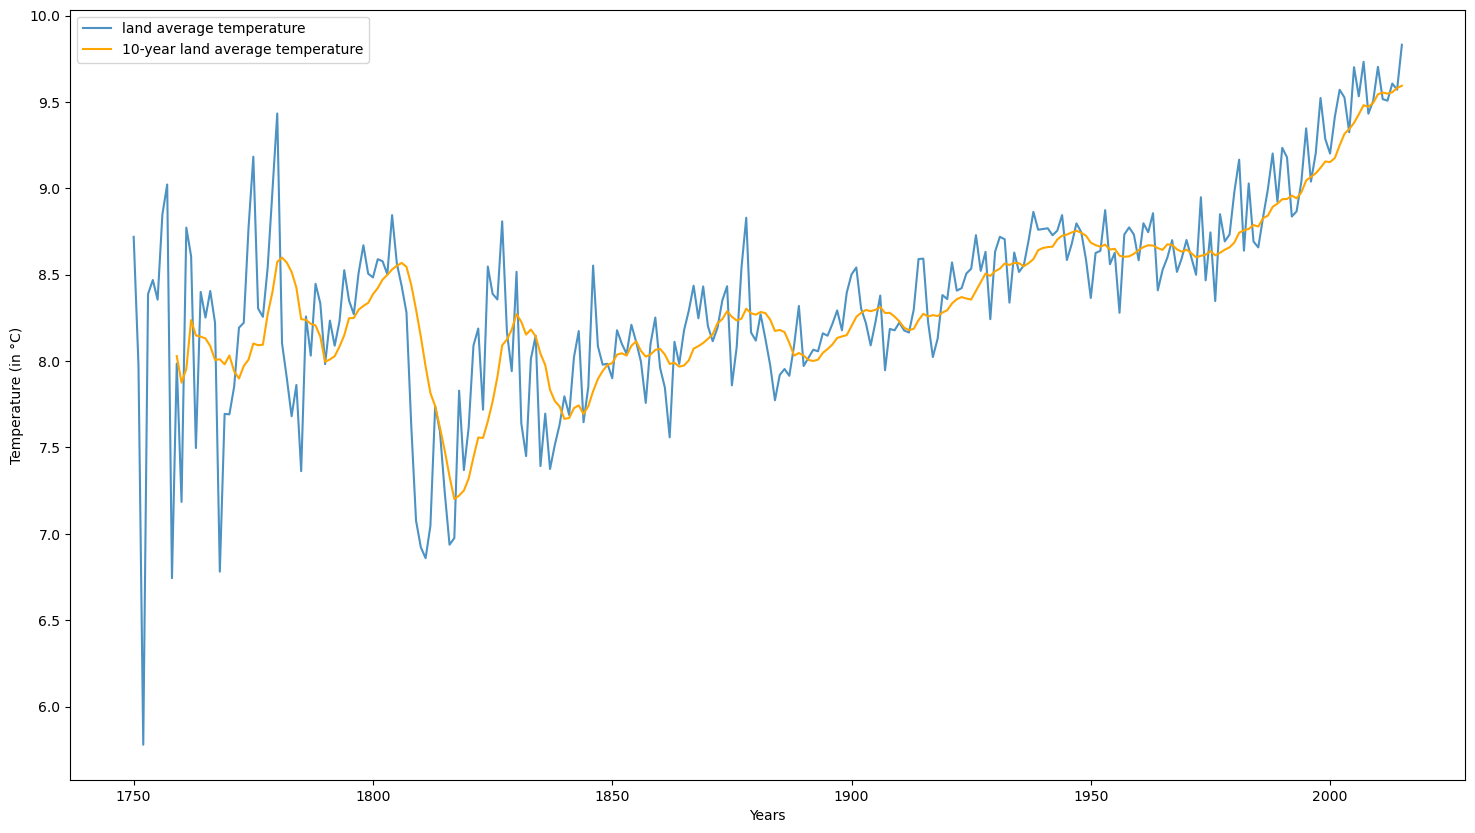

<Figure size 640x480 with 0 Axes>

In [8]:

temperature_px = df['LandAverageTemperature']
df['10'] = temperature_px.rolling(window=10).mean()

plt.figure(figsize=(18,10))
ax = plt.subplot()
ax.plot(df['LandAverageTemperature'], alpha=0.8, label='land average temperature')
ax.plot(df['10'], color="orange", label='10-year land average temperature')
ax.set_xticks([0,50,100,150,200,250])
ax.set_xticklabels([1750,1800,1850,1900,1950,2000])
plt.xlabel('Years')
plt.ylabel('Temperature (in °C)')
#plt.grid()
plt.legend()
plt.show()
plt.clf()



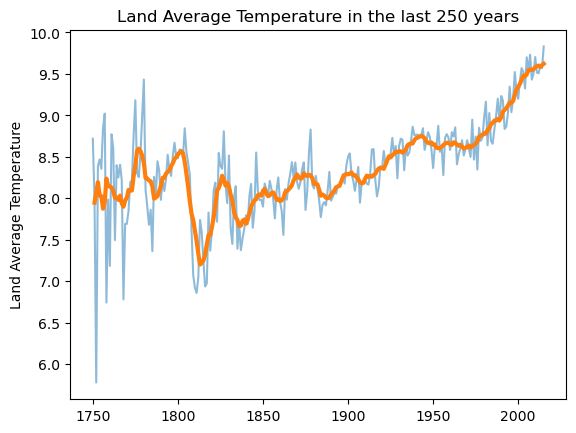

In [9]:
trend = df['LandAverageTemperature'].rolling(
    window=10,
    center=True,
    min_periods=6,
).mean()

ax = df['LandAverageTemperature'].plot( alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)
ax.set(title="Land Average Temperature in the last 250 years", ylabel="Land Average Temperature")
ax.set_xticks([0,50,100,150,200,250])
ax.set_xticklabels([1750,1800,1850,1900,1950,2000])
plt.show()

<blockquote style="border-left: 5px solid #686a91;">Dans ce code ci-dessous nous appliquons une technique de diffusion des données (forecasting)</blocquote>

In [10]:
from statsmodels.tsa.deterministic import DeterministicProcess

average_temperature = temperatures.groupby('Year').mean()['LandAverageTemperature']
y = average_temperature.copy().fillna(average_temperature.mean())  # the target

# appropriate for a cubic trend model
dp = DeterministicProcess(index=y.index, order=3)
X = dp.in_sample()
X_fore = dp.out_of_sample(steps=90)

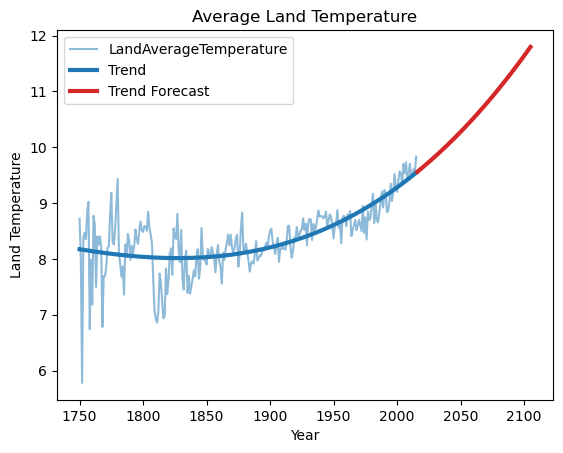

In [11]:

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot( alpha=0.5, title="Average Land Temperature", ylabel="Land Temperature")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();



### Regression linéaire

In [12]:
corr, p = pearsonr(df['Year'], df['LandAverageTemperature'])
print('Pearson correlation of Year and Land Average Temperature: ' + str(corr))

Pearson correlation of Year and Land Average Temperature: 0.6223364823755806


In [13]:
lr = LinearRegression()

In [14]:

X = df['Year']
y = df['LandAverageTemperature']

X = X.values.reshape(-1,1)



In [15]:
lr.fit(X, y)

LinearRegression()

In [16]:
y_pred = lr.predict(X)

In [17]:
years = pd.DataFrame(X)

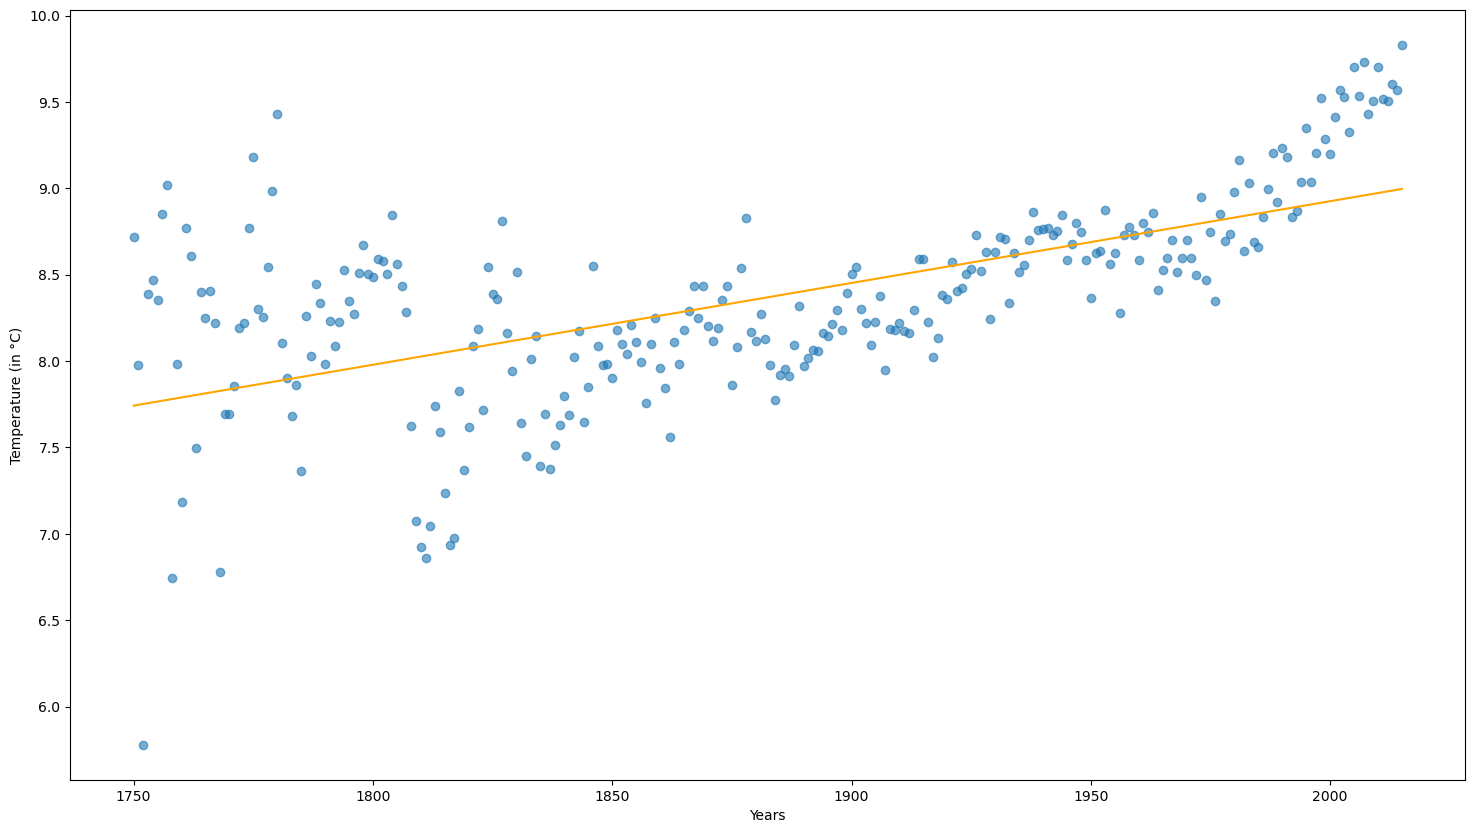

<Figure size 640x480 with 0 Axes>

In [18]:
plt.figure(figsize=(18,10))
plt.scatter(X, y, alpha=0.6)
plt.plot(X, y_pred, color="orange")
plt.xlabel('Years')
plt.ylabel('Temperature (in °C)')
plt.show()
plt.clf()

In [19]:


print(lr.coef_)
print(10 * lr.coef_)


[0.00473169]
[0.04731692]


In [20]:


print(lr.predict(np.array([2030, 2050]).reshape(-1,1)))



[9.06726169 9.16189553]


#### Interpretation
<blockquote style="border-left: 5px solid #686a91;">
Chaque année, la température moyenne des surfaces terrestres augmente en moyenne de 0.004 °C. Tous les dix ans, la température moyenne des terres augmente en moyenne de 0.047 °C. La température moyenne des terres en 2030 sera de 9.06 °C et en 2050 de 9.16 °C.</blocquote>

#### Données de 1950 - 2015

In [21]:
corr, p = pearsonr(df[df['Year'] >= 1950]['Year'], df[df['Year'] >= 1950]['LandAverageTemperature'])
print('Pearson correlation of Year and Land Average Temperature: ' + str(corr))

Pearson correlation of Year and Land Average Temperature: 0.8698038878923113


In [22]:


lr = LinearRegression()


In [23]:
X = df[df['Year'] >= 1950]['Year']
y = df[df['Year'] >= 1950]['LandAverageTemperature']

X = X.values.reshape(-1,1)

In [24]:


lr.fit(X, y)


LinearRegression()

In [25]:

y_pred = lr.predict(X)


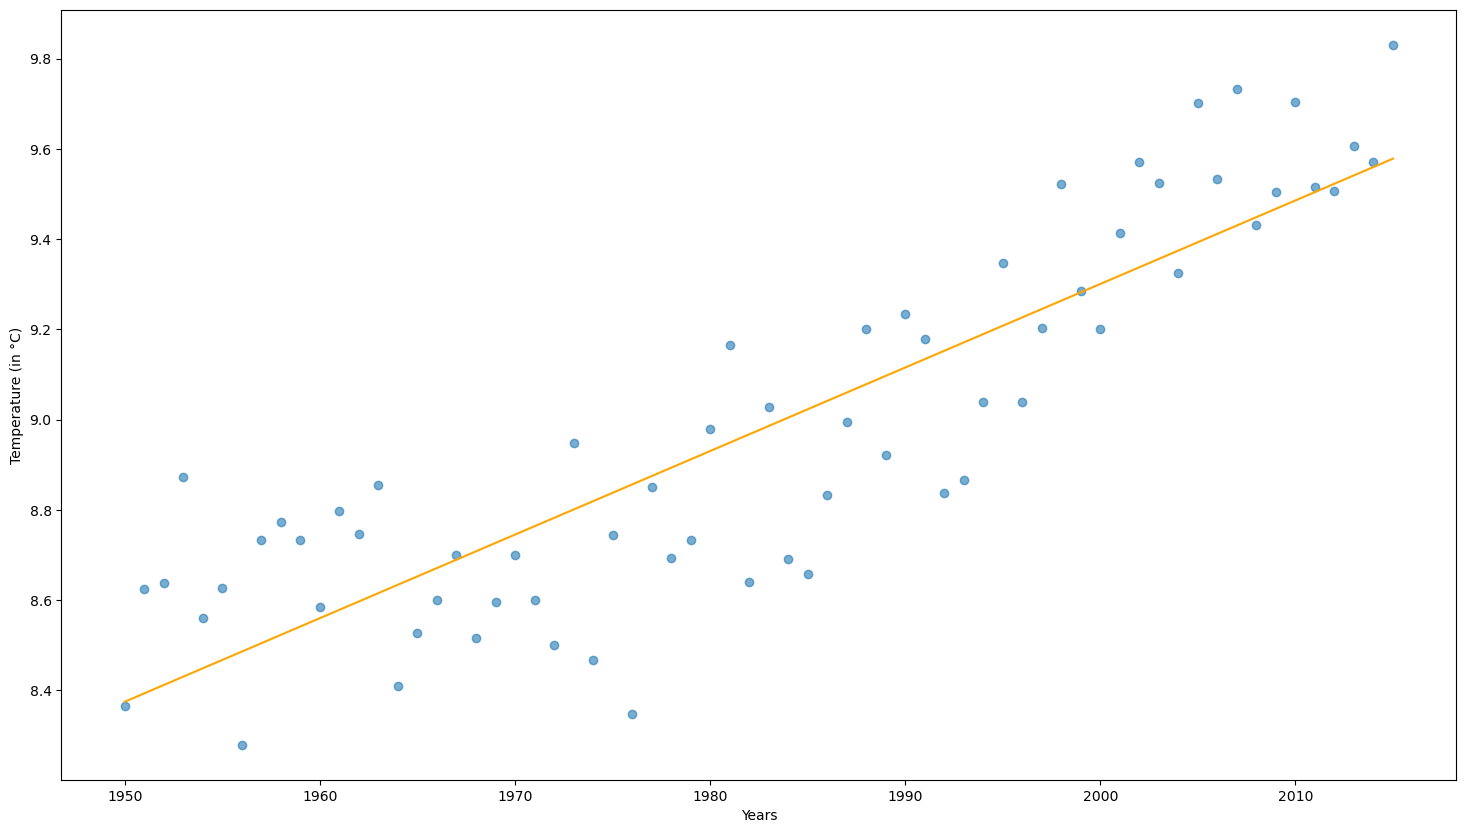

<Figure size 640x480 with 0 Axes>

In [26]:


plt.figure(figsize=(18,10))
plt.scatter(X, y, alpha=0.6)
plt.plot(X, y_pred, color="orange")
plt.xlabel('Years')
plt.ylabel('Temperature (in °C)')
plt.show()
plt.clf();



In [27]:
print(lr.coef_)
print(lr.coef_ * 10)

[0.01851674]
[0.18516745]


In [28]:

print(lr.predict(np.array([2030, 2050]).reshape(-1,1)))



[ 9.85627013 10.22660503]


#### Interpretation
<blockquote style="border-left: 5px solid #686a91;">
Chaque année, la température moyenne des surfaces terrestres augmente en moyenne de 0,018 °C. Tous les dix ans, la température moyenne des terres augmente en moyenne de 0,185 °C. La température moyenne des terres en 2030 sera de 9.85°C et en 2050 de 10.22 °C.</blocquote>

In [29]:
print("Ce code est adapté à partir d'un notebook de kaggle (https://www.kaggle.com/code/siddharthnishtala/basic-polynomial-regression-india)")
print("Donnons un crédit à siddharthnishtala")

Ce code est adapté à partir d'un notebook de kaggle (https://www.kaggle.com/code/siddharthnishtala/basic-polynomial-regression-india)
Donnons un crédit à siddharthnishtala


In [30]:
from sklearn.utils import shuffle
from sklearn import linear_model

df = pd.read_csv("GlobalLandTemperaturesByCountry.csv", index_col=0, parse_dates=True)

# Selectionnons les données dont les lignes sont uniquement pour la france
df = df.loc[df["Country"]=="France"]

df = df.dropna(subset = ["AverageTemperature"])

# Mélangez l'ensemble de données après avoir sélectionné la température moyenne de la colonne
temp = shuffle(df["AverageTemperature"])

# Calcul du nombre de jours depuis le jour 1 dans l'ensemble de données, c'est-à-dire 1796-01-01
days_since = pd.Series((temp.keys().year * 365 + temp.keys().month * 30 + temp.keys().day) - (1796*365 + 1*30 + 1),index=temp.keys(),name="DaysSince")

# Concaténons temp et le day_since de la série pour créer un dataframe 'data' avec toutes les données nécessaires pour la régression linéaire de base
data = pd.concat([temp, days_since],axis=1)

display(df)

,AverageTemperature,AverageTemperatureUncertainty,Country
dt,,,
1743-11-01,10.203,2.030,France
1744-04-01,13.190,2.280,France
1744-05-01,14.133,1.891,France
1744-06-01,17.349,1.926,France
1744-07-01,18.782,1.994,France
...,...,...,...
2013-04-01,12.320,0.240,France
2013-05-01,13.763,0.269,France
2013-06-01,17.750,0.295,France


In [31]:
# Division des données mélangées en un ensemble d'apprentissage et un ensemble de test
train = data.iloc[:-int(len(data)*.2)]
test = data.iloc[-int(len(data)*.2):]

# Utilisation du modèle linéaire de Sci-kit Learn pour entraîner une régression linéaire
regr = linear_model.LinearRegression()
regr.fit(train["DaysSince"].to_frame(), train["AverageTemperature"].to_frame())

# Impression des coefficients après entraînement du modèle de régression linéaire sur les données d'entraînement
print('Coefficients: \n', regr.coef_)
# # affichage du mean squared error calculée à partir des données de l'ensemble de test 
print("Mean squared error: %.2f"
      % pd.DataFrame.mean((regr.predict(test["DaysSince"].to_frame()) - test["AverageTemperature"].to_frame()) ** 2))

# affichage du score de variance sur le jeu de test
print('Variance score: %.2f' % regr.score(test["DaysSince"].to_frame(), test["AverageTemperature"].to_frame()))

Coefficients: 
 [[1.25376118e-05]]
Mean squared error: 25.13
Variance score: -0.01


In [32]:
# Prédire la température de 2030
days_since_2030 = pd.Series((pd.to_datetime("2030-01-01").year * 365 + pd.to_datetime("2030-01-01").month * 30 + pd.to_datetime("2030-01-01").day) - (1796*365 + 1*30 + 1), name="DaysSince")
temperature_2030 = regr.predict(days_since_2030.to_frame())

# Afficher la température prédite pour 2030
print("Température prédite pour la France en 2030:", round(temperature_2030[0][0], 3))

# Prédire la température de 2050
days_since_2050 = pd.Series((pd.to_datetime("2050-01-01").year * 365 + pd.to_datetime("2050-01-01").month * 30 + pd.to_datetime("2050-01-01").day) - (1796*365 + 1*30 + 1), name="DaysSince")
temperature_2050 = regr.predict(days_since_2050.to_frame())

# Afficher la température prédite pour 2050
print("Température prédite pour la France en 2050:", round(temperature_2050[0][0], 3))

# Prédire la température de 2100
days_since_2100 = pd.Series((pd.to_datetime("2100-01-01").year * 365 + pd.to_datetime("2100-01-01").month * 30 + pd.to_datetime("2100-01-01").day) - (1796*365 + 1*30 + 1), name="DaysSince")
temperature_2100 = regr.predict(days_since_2100.to_frame())

# Afficher la température prédite pour 2100
print("Température prédite pour la France en 2100:", round(temperature_2100[0][0], 3))


Température prédite pour la France en 2030: 13.402
Température prédite pour la France en 2050: 13.493
Température prédite pour la France en 2100: 13.722
